In [ ]:

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [9]:
import os
import pandas as pd
def load_housing_data():
    
    return pd.read_csv("housing.csv")



housing = load_housing_data()

In [10]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [ ]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)


# 根据收入类别进行分层抽样了。使用Scikit-Learn的
# Stratified-Shuffle Split类

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set


# print(housing)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6


# 类的功能是为原数据集添加新的特征，X[:,3]表示的是第4列所有数据，np.c_表示的是拼接数组。
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]



In [ ]:
from sklearn.base import TransformerMixin #gives fit_transform method for free
from sklearn.preprocessing import LabelBinarizer


class MyLabelBinarizer(TransformerMixin):

    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)

    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self

    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [ ]:
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer
from sklearn.pipeline import FeatureUnion, Pipeline



housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
# print(num_attribs)
cat_attribs = ["ocean_proximity"]


num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])


cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer',MyLabelBinarizer()),
])


full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

# print(housing)
housing_prepared = full_pipeline.fit_transform(housing)
# print(housing_prepared)

以上先准备数据

1.使用不同的超参数，如kernel="linear"（具有C超参数的多种值）或kernel="rbf"（C超参数和gamma超参数的多种值），尝试一个支持向量机回归器

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100.]},
        {'kernel': ['rbf'], 'C': [1.0]}
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   58.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   58.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0]}, {'kernel': ['rbf'], 'C': [1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):


In [15]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)

71923.9740992


In [16]:
grid_search.best_params_

{'C': 100.0, 'kernel': 'linear'}

尝试用RandomizedSearchCV替换GridSearchCV

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 100),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023C4C4EA160>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023C4C4C0400>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [20]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

75363.456290375951

In [21]:
rnd_search.best_params_

{'C': 36.544523552132475, 'gamma': 3.010121430917521, 'kernel': 'linear'}

**exponential distribution**
指数分布

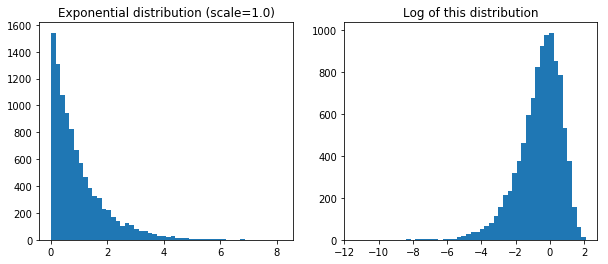

In [22]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

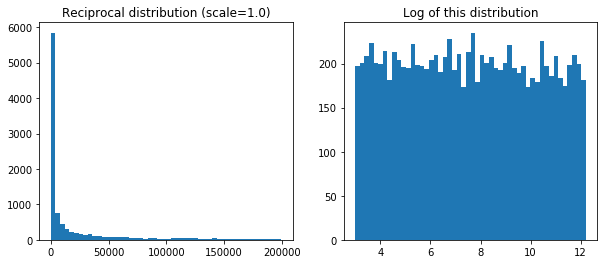

In [23]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

尝试在准备流水线中添加一个转换器，从而只选出最重要的属性。

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a RandomForestRegressor). You may be tempted to compute them directly in the TopFeatureSelector's fit() method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

In [25]:
k = 5

In [27]:
# top_k_feature_indices = indices_of_top_k(feature_importances, k)
# top_k_feature_indices